## Data loading and preparing

### Prerequisites

In [2]:
!python --version

Python 3.10.13


In [3]:
from hsl_mm_fit.utils import utils, plotting
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
# import numpy as np
# import csv
# print(np.__version__)
# print(csv.__version__)

1.26.4
1.0


### Data loading

In [4]:
# data of the desired modalities of data from MM-Fit dataset
MODALITIES = [
    'sw_r_acc', # right hand smartwatch accelerometer data
    'sw_r_gyr', # right hand smartwatch gyroscope data
    'sw_l_acc', # left hand smartwatch accelerometer data
    'sw_l_gyr'  # left hand smartwatch gyroscope data
]

# IDs of the desired workouts from MM-Fit dataset
WORKOUT_IDS = ['w00', 'w01', 'w02', 'w03', 'w04', 'w05', 'w06', 'w07', 'w08',
               'w09', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17',
               'w18', 'w19', 'w20']

# dictionary to store the data for each modality
data_per_modality = {}
for MODALITY in MODALITIES:
    data_per_modality[MODALITY] = {}

sets_info = {}

In [5]:
for ID in WORKOUT_IDS:
  # base path for the data
    data_dir = os.path.join('hsl_mm_fit/dataset', ID)
    sets_info[ID] = utils.load_labels(os.path.join(data_dir, 
                                                   ID + '_labels.csv'))
    for MODALITY in MODALITIES:
        data_per_modality[MODALITY][ID] = utils.load_modality(
            os.path.join(data_dir, ID + '_' + MODALITY + '.npy')
        )
        
for MODALITY in MODALITIES:
    data_per_modality[MODALITY] = {
        k: v for k, v in data_per_modality[MODALITY].items() if v is not None
    }

### Visualize some data

In [ ]:
plotting.plot_sensor(data_per_modality['sw_r_acc']['w00'], data_type='acc',
            title='Smartwatch Right Accelerometer', overlay=True)
plotting.plot_sensor(data_per_modality['sw_r_gyr']['w00'], data_type='gyr',
            title='Smartwatch Right Gyroscope', overlay=True)
plotting.plot_sensor(data_per_modality['sw_l_acc']['w00'], data_type='acc',
            title='Smartwatch Left Accelerometer', overlay=True)
plotting.plot_sensor(data_per_modality['sw_l_gyr']['w00'], data_type='gyr',
            title='Smartwatch Left Gyroscope', overlay=True)

In [ ]:
# plot data for one set of pushups per modality per repetition

for label in sets_info['w00']:
  if label[3] == 'pushups':
    for mod_type, mod_data in data_per_modality.items():
      # plot per repetition
      total_reps = label[2]
      start_frame = label[0]
      end_frame = label[1]
      frames_per_rep = int((end_frame - start_frame) / total_reps)
      for i in range(total_reps):
        mod_subset = utils.get_subset(mod_data['w00'],
                                start=(start_frame + (i * frames_per_rep)),
                                end=(start_frame + ((i + 1) * frames_per_rep)))
        print(mod_type, mod_data['w00'].shape)
        data_type = ''
        if 'acc' in mod_type:
          data_type = 'acc'
        elif 'gyr' in mod_type:
          data_type = 'gyr'
        else:
          raise Exception('Ops, something wrong is going on!')
        plotting.plot_sensor(mod_subset, data_type=data_type,
                    title=mod_type + f' (rep {i})', overlay=True,
                    use_timestamps=True)
        plotting.plot_sensor(mod_subset, data_type=data_type,
                    title=mod_type + f' (rep {i})', overlay=True,
                    use_timestamps=False)
    break

### Organize the data

In [6]:
EXERCISES = ['squats', 'pushups', 'dumbbell_shoulder_press', 'lunges',
             'dumbbell_rows', 'situps', 'tricep_extensions', 'bicep_curls',
             'lateral_shoulder_raises', 'jumping_jacks']

filtered_data_per_feature = {
    'X_sw_l_acc':     [], 'Y_sw_l_acc':     [], 'Z_sw_l_acc':     [],
    'X_sw_l_acc_mag': [], 'Y_sw_l_acc_mag': [], 'Z_sw_l_acc_mag': [],
    'X_sw_l_acc_ph':  [], 'Y_sw_l_acc_ph':  [], 'Z_sw_l_acc_ph':  [],
    'X_sw_r_acc':     [], 'Y_sw_r_acc':     [], 'Z_sw_r_acc':     [],
    'X_sw_r_acc_mag': [], 'Y_sw_r_acc_mag': [], 'Z_sw_r_acc_mag': [],
    'X_sw_r_acc_ph':  [], 'Y_sw_r_acc_ph':  [], 'Z_sw_r_acc_ph':  [],
    'X_sw_l_gyr':     [], 'Y_sw_l_gyr':     [], 'Z_sw_l_gyr':     [],
    'X_sw_l_gyr_mag': [], 'Y_sw_l_gyr_mag': [], 'Z_sw_l_gyr_mag': [],
    'X_sw_l_gyr_ph':  [], 'Y_sw_l_gyr_ph':  [], 'Z_sw_l_gyr_ph':  [],
    'X_sw_r_gyr':     [], 'Y_sw_r_gyr':     [], 'Z_sw_r_gyr':     [],
    'X_sw_r_gyr_mag': [], 'Y_sw_r_gyr_mag': [], 'Z_sw_r_gyr_mag': [],
    'X_sw_r_gyr_ph':  [], 'Y_sw_r_gyr_ph':  [], 'Z_sw_r_gyr_ph':  [],
    'label': [], 'reps': []
}

axes = ['X', 'Y', 'Z']

fft_output_len = 2048

for ID in WORKOUT_IDS:
  for set_info in sets_info[ID]:
    # print(label)
    start_frame    = set_info[0]
    end_frame      = set_info[1]
    reps           = set_info[2]
    exercise_label = set_info[3]
    filtered_data_per_feature['label'].append(exercise_label)
    filtered_data_per_feature['reps'].append(reps)
    for MODALITY in MODALITIES:
      mod_subset = utils.get_subset(data_per_modality[MODALITY][ID],
                              start=start_frame,
                              end=end_frame)
      i = 0
      for axis in axes:
        filtered_data_per_feature[axis + '_' + MODALITY].append(mod_subset[:,2+i])
        data_fft = np.fft.fft(mod_subset[:,2+i], n=fft_output_len, norm='ortho')
        filtered_data_per_feature[axis + '_' + MODALITY + '_mag'].append(np.abs(data_fft))
        filtered_data_per_feature[axis + '_' + MODALITY + '_ph'].append(np.angle(data_fft))
        i += 1

In [21]:
mins_acc = []
maxs_acc = []
mins_gyr = []
maxs_gyr = []
min_record_len = None
max_record_len = None
avg_record_len = 0
for d in filtered_data_per_feature['X_sw_l_acc']:
  mins_acc.append(min(d))
  maxs_acc.append(max(d))
  avg_record_len += len(d)
  if max_record_len == None:
    max_record_len = len(d)
  elif len(d) > max_record_len:
    max_record_len = len(d)
  if min_record_len == None:
    min_record_len = len(d)
  elif len(d) < min_record_len:
      min_record_len = len(d)
for d in filtered_data_per_feature['X_sw_r_acc']:
  mins_acc.append(min(d))
  maxs_acc.append(max(d))
for d in filtered_data_per_feature['Y_sw_l_acc']:
  mins_acc.append(min(d))
  maxs_acc.append(max(d))
for d in filtered_data_per_feature['Y_sw_r_acc']:
  mins_acc.append(min(d))
  maxs_acc.append(max(d))
for d in filtered_data_per_feature['Z_sw_l_acc']:
  mins_acc.append(min(d))
  maxs_acc.append(max(d))
for d in filtered_data_per_feature['Z_sw_r_acc']:
  mins_acc.append(min(d))
  maxs_acc.append(max(d))
for d in filtered_data_per_feature['X_sw_l_gyr']:
  mins_gyr.append(min(d))
  maxs_gyr.append(max(d))
for d in filtered_data_per_feature['X_sw_r_gyr']:
  mins_gyr.append(min(d))
  maxs_gyr.append(max(d))
for d in filtered_data_per_feature['Y_sw_l_gyr']:
  mins_gyr.append(min(d))
  maxs_gyr.append(max(d))
for d in filtered_data_per_feature['Y_sw_r_gyr']:
  mins_gyr.append(min(d))
  maxs_gyr.append(max(d))
for d in filtered_data_per_feature['Z_sw_l_gyr']:
  mins_gyr.append(min(d))
  maxs_gyr.append(max(d))
for d in filtered_data_per_feature['Z_sw_r_gyr']:
  mins_gyr.append(min(d))
  maxs_gyr.append(max(d))
max_acc = max(maxs_acc)
max_gyr = max(maxs_gyr)
min_acc = min(mins_acc)
min_gyr = min(mins_gyr)
avg_record_len /= len(filtered_data_per_feature['X_sw_l_acc'])
print(f'max acc is {max_acc}, min acc is {min_acc}')
print(f'max gyr is {max_gyr}, min gyr is {min_gyr}')
print(f'max record length is {max_record_len}, min record length is {min_record_len}, average record length is {avg_record_len}')

max acc is 78.47042, min acc is -78.48
max gyr is 24.46686, min gyr is -19.598993
max record length is 3788, min record length is 137, average record length is 2124.806818181818


### Train model

In [7]:
print(f'TensorFlow version is {tf.__version__}\n')

TensorFlow version is 2.10.0



In [8]:
# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

SAMPLES_PER_EXERCISE = fft_output_len
NUM_EXERCISES = len(EXERCISES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_EXERCISES = np.eye(NUM_EXERCISES)

# print(ONE_HOT_ENCODED_EXERCISES)

inputs = []
outputs = []

for i in range(len(filtered_data_per_feature['label'])):
  exercise_label = filtered_data_per_feature['label'][i]
  output = ONE_HOT_ENCODED_EXERCISES[EXERCISES.index(exercise_label)]
  # print(f"Processing exercise {exercise_label}...")
  record_len = len(filtered_data_per_feature['X_sw_l_acc_mag'])
  tensor = []
  for j in range(record_len):
    for MODALITY in MODALITIES:
      if ('_l_' in MODALITY):
        tensor += [
          filtered_data_per_feature['X_' + MODALITY + '_mag'][i][j],
          filtered_data_per_feature['Y_' + MODALITY + '_mag'][i][j],
          filtered_data_per_feature['Z_' + MODALITY + '_mag'][i][j]
          # filtered_data_per_feature['X_' + modality + '_ph'][i][j],
          # filtered_data_per_feature['Y_' + modality + '_ph'][i][j],
          # filtered_data_per_feature['Z_' + modality + '_ph'][i][j]
        ]
  inputs.append(tensor)
  outputs.append(output)

print("Data set parsing and preparation complete.")

Data set parsing and preparation complete.


In [9]:
inputs = np.array(inputs)
outputs = np.array(outputs)

# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# print(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

In [10]:
# build the model and train it

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min',
                                            patience=100, 
                                            restore_best_weights=True)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(80, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dropout(0.1)) # relu is used for performance
model.add(tf.keras.layers.Dense(20, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(NUM_EXERCISES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=500, batch_size=32, validation_data=(inputs_validate, outputs_validate), callbacks=[callback])



Epoch 1/500
12/12 [==============================] - 1s 62ms/step - loss: 0.1427 - mae: 0.1747 - accuracy: 0.1301 - val_loss: 0.1164 - val_mae: 0.1726 - val_accuracy: 0.1371
Epoch 2/500
12/12 [==============================] - 0s 5ms/step - loss: 0.1189 - mae: 0.1648 - accuracy: 0.1924 - val_loss: 0.1112 - val_mae: 0.1630 - val_accuracy: 0.2339
Epoch 3/500
12/12 [==============================] - 0s 4ms/step - loss: 0.1063 - mae: 0.1635 - accuracy: 0.1978 - val_loss: 0.0880 - val_mae: 0.1689 - val_accuracy: 0.2258
Epoch 4/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0851 - mae: 0.1649 - accuracy: 0.2412 - val_loss: 0.0745 - val_mae: 0.1548 - val_accuracy: 0.3952
Epoch 5/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0787 - mae: 0.1444 - accuracy: 0.3144 - val_loss: 0.0649 - val_mae: 0.1307 - val_accuracy: 0.4032
Epoch 6/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0658 - mae: 0.1249 - accuracy: 0.4417 - val_loss: 0.0598 - 

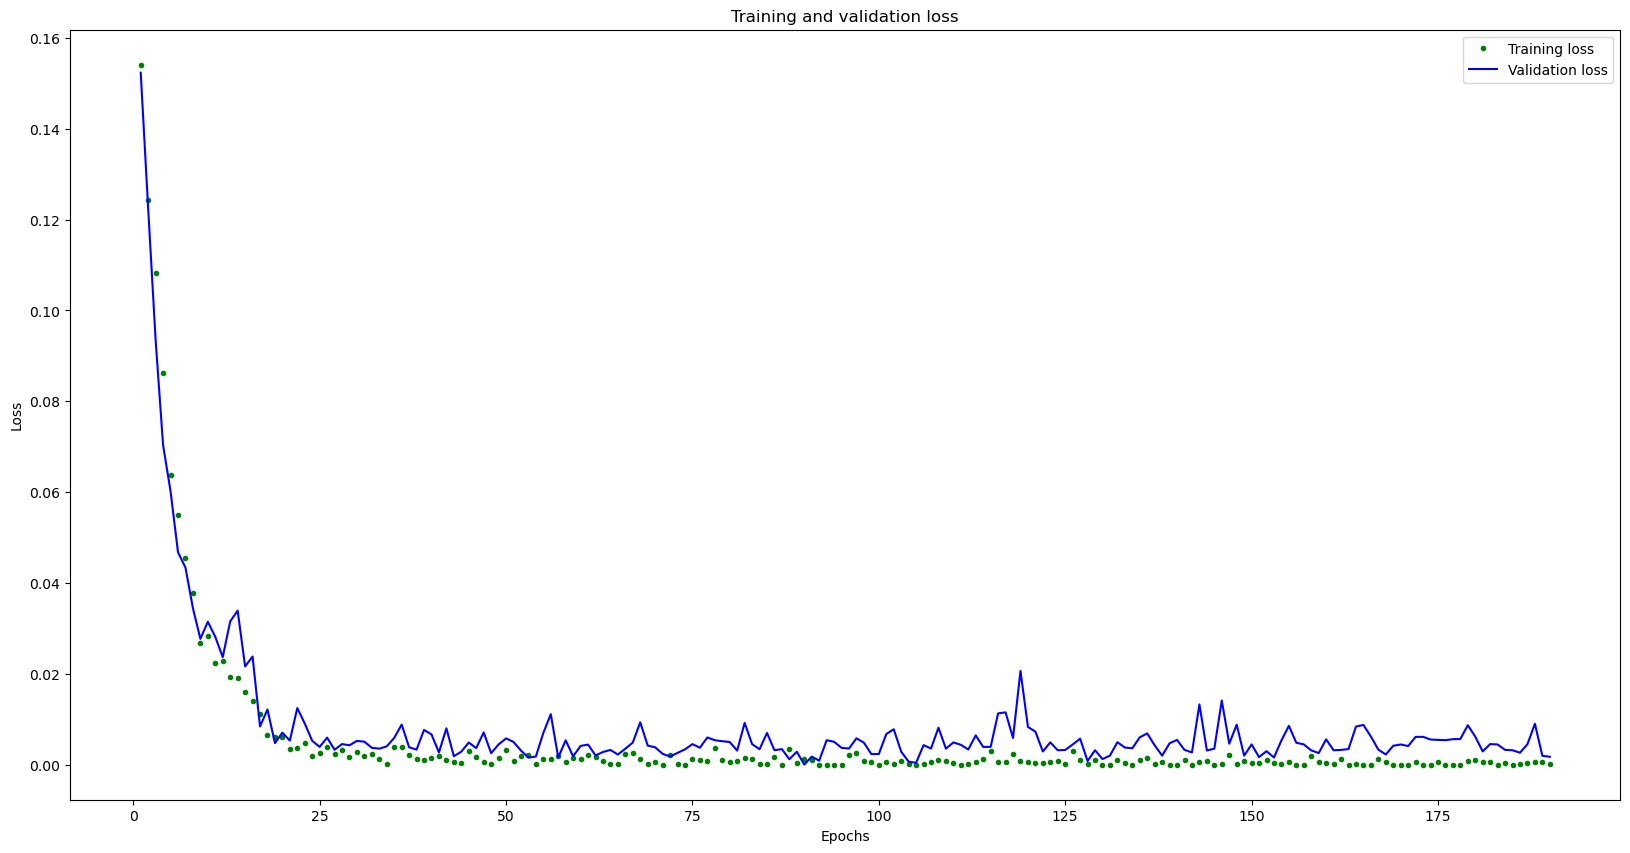

[20.0, 10.0]


In [33]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

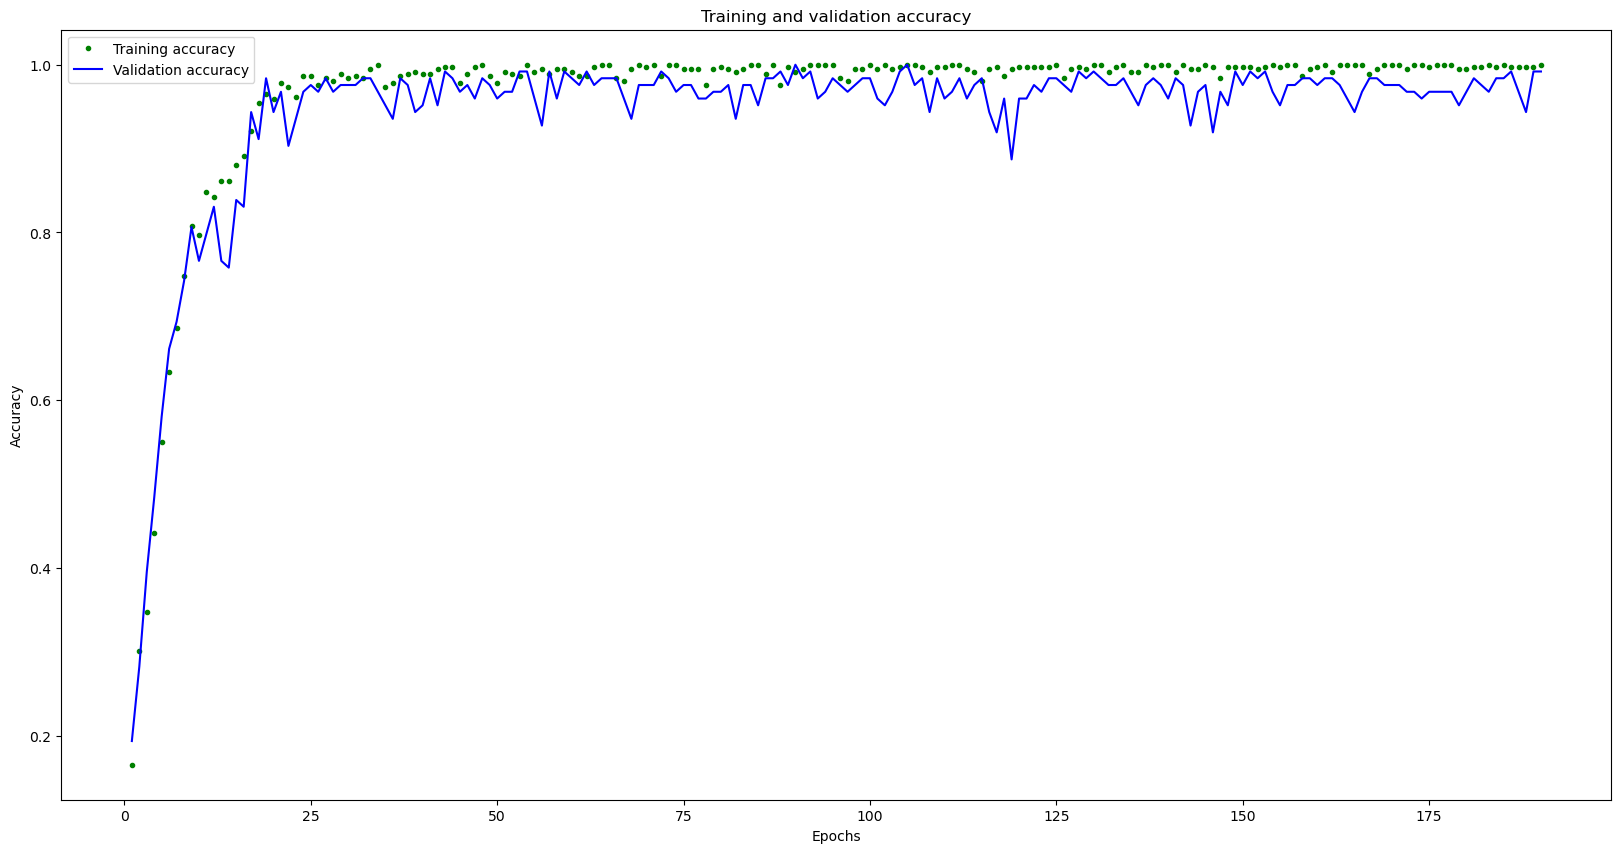

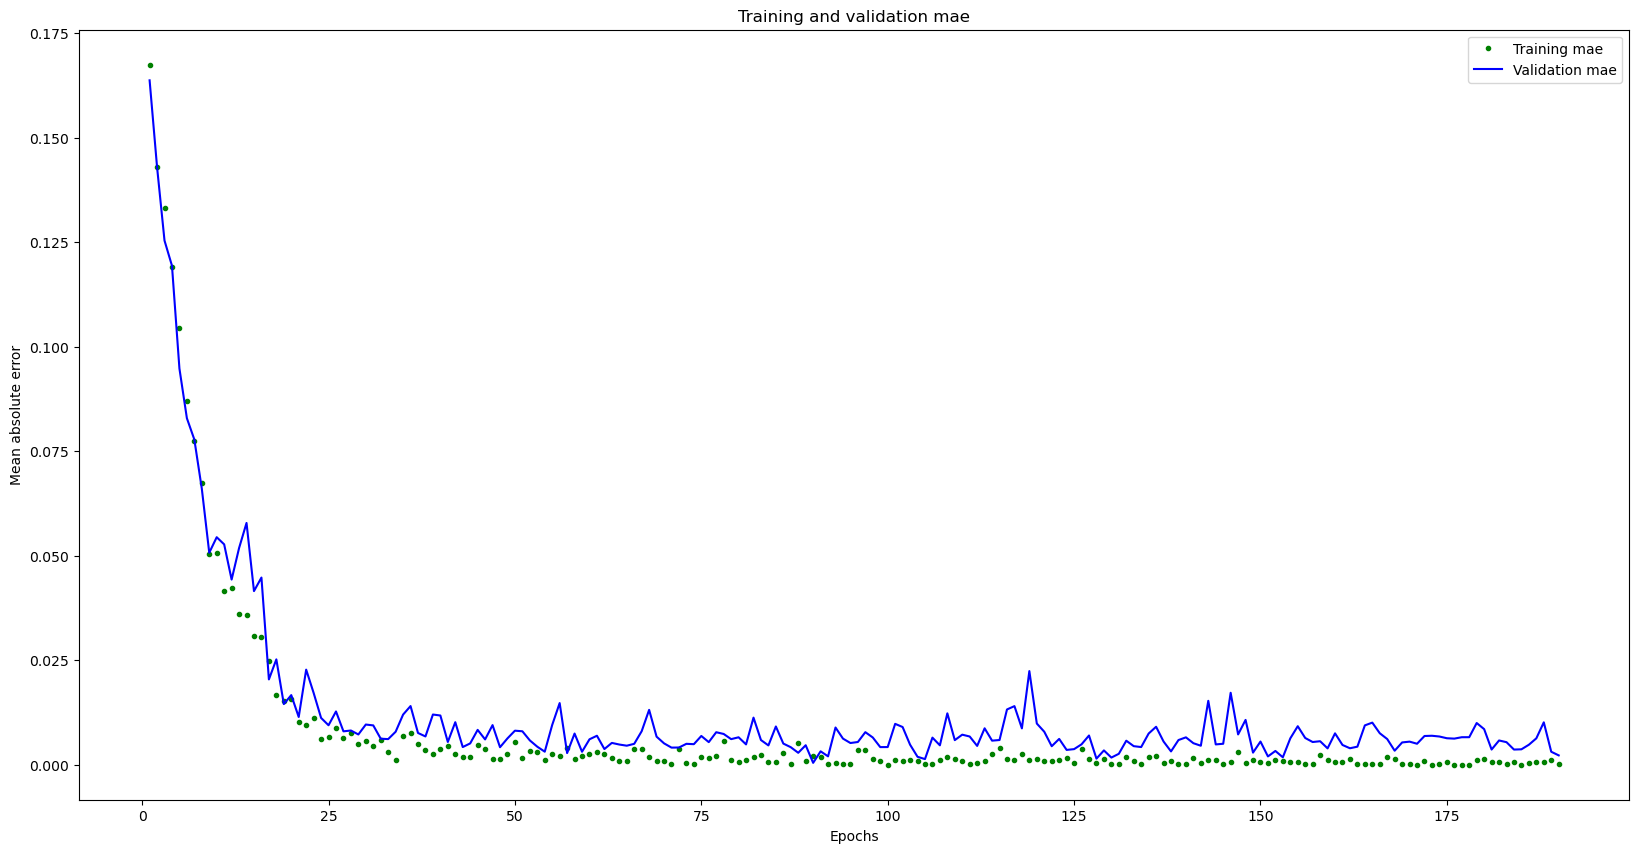

In [34]:
# graph the loss, the model above is configure to use "mean squared error" as the loss function
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'g.', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'g.', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('Mean absolute error')
plt.legend()
plt.show()

In [ ]:
# graph the loss again skipping a bit of the start
# SKIP = 100
# plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
# plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# graph of mean absolute error
# mae = history.history['mae']
# val_mae = history.history['val_mae']
# plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
# plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
# plt.title('Training and validation mean absolute error')
# plt.xlabel('Epochs')
# plt.ylabel('MAE')
# plt.legend()
# plt.show()

In [35]:
# use the model to predict the test inputs

num_of_test_inputs = len(inputs_test)

print(f'Classifying test dataset with {num_of_test_inputs} inputs...\n')

predictions = model.predict(inputs_test)

incorrect_predictions = 0

# print the predictions and the expected ouputs
for i in range(num_of_test_inputs):
  pred_max = max(predictions[i])
  actual_max = max(outputs_test[i])
  if (pred_max < 0.8):
    print(f'low classification probability ({pred_max})!')
    print()
  predicted_exercise = EXERCISES[list(predictions[i]).index(pred_max)]
  actual_exercise    = EXERCISES[list(outputs_test[i]).index(actual_max)]
  if (predicted_exercise != actual_exercise):
    incorrect_predictions += 1
    print('prediction:\t', np.round(predictions[i], decimals=3))
    print('actual:\t\t', outputs_test[i])
    print(f'predicted {predicted_exercise} and was {actual_exercise}')
    print()

correct_predictions = num_of_test_inputs - incorrect_predictions
correct_predictions_percentage = (num_of_test_inputs - incorrect_predictions) / num_of_test_inputs
incorrect_predictions_percentage = 1 - correct_predictions_percentage
print(f'Got {incorrect_predictions} ({incorrect_predictions_percentage}) predictions wrong and '
      + f'{correct_predictions} ({correct_predictions_percentage}) predictions right')

Classifying test dataset with 123 inputs...

4/4 [==============================] - 0s 39ms/step
low classification probability (0.5082735419273376)!

prediction:	 [0.    0.    0.492 0.    0.508 0.    0.    0.    0.    0.   ]
actual:		 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
predicted dumbbell_rows and was dumbbell_shoulder_press

low classification probability (0.7428851127624512)!

low classification probability (0.5542124509811401)!

prediction:	 [0.009 0.008 0.    0.    0.001 0.002 0.001 0.068 0.911 0.   ]
actual:		 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
predicted lateral_shoulder_raises and was bicep_curls

prediction:	 [0.    0.007 0.003 0.    0.    0.946 0.    0.    0.    0.043]
actual:		 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
predicted situps and was jumping_jacks

Got 3 (0.024390243902439046) predictions wrong and 120 (0.975609756097561) predictions right


### Convert model

In [24]:
# Convert the model to the TensorFlow Lite format without quantization

converter_baseline = tf.lite.TFLiteConverter.from_keras_model(model)
baseline_model = converter_baseline.convert()

# Save the model to disk
baseline_model_dir = os.path.join('models','baseline_model.tflite')
open(baseline_model_dir, 'wb').write(baseline_model)

baseline_model_size = os.path.getsize(baseline_model_dir)
print(f'Baseline model has {baseline_model_size} bytes')

INFO:tensorflow:Assets written to: C:\Users\P\AppData\Local\Temp\tmpaa8rla23\assets


INFO:tensorflow:Assets written to: C:\Users\P\AppData\Local\Temp\tmpaa8rla23\assets


Baseline model has 1192452 bytes


In [25]:
# Convert the model to the TensorFlow Lite format with quantization

converter_optimized = tf.lite.TFLiteConverter.from_keras_model(model)
converter_optimized.optimizations = [tf.lite.Optimize.DEFAULT]
converter_optimized.target_spec.suported_types = [tf.float16]
optimized_model = converter_optimized.convert()

# Save the model to disk
optimized_model_dir = os.path.join('models','optimized_model.tflite')
open(optimized_model_dir, 'wb').write(optimized_model)

optimized_model_size = os.path.getsize(optimized_model_dir)
print(f'Optimized model has {optimized_model_size} bytes')

INFO:tensorflow:Assets written to: C:\Users\P\AppData\Local\Temp\tmpkp32v9e0\assets


INFO:tensorflow:Assets written to: C:\Users\P\AppData\Local\Temp\tmpkp32v9e0\assets


Optimized model has 300744 bytes


In [26]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(optimized_model_dir)
interpreter.allocate_tensors()

# Function for evaluating TF Lite Model over Test Images
def evaluate(interpreter):
  prediction= []
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  input_format = interpreter.get_output_details()[0]['dtype']

  for i, input in enumerate(inputs_test):
    if i % 100 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    input = np.expand_dims(input, axis=0).astype(input_format)
    interpreter.set_tensor(input_index, np.float32(input))

    # Run inference.
    interpreter.invoke()
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    prediction.append(predicted_label)

  print('\n')
  # Comparing prediction results with ground truth labels to calculate accuracy.
  prediction = np.array(prediction)
  # print(prediction)
  used_outputs = []
  for output in outputs_test:
    used_outputs += [np.argmax(output)]
  # print(used_outputs)
  accuracy = (prediction == used_outputs).mean()
  return accuracy

test_accuracy = evaluate(interpreter)
print('\nFloat 16 Quantized TFLite Model Test Accuracy:', test_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.


[1 8 6 3 6 1 1 3 2 9 7 7 1 4 7 7 3 4 1 4 0 2 9 4 5 4 4 4 8 6 4 3 0 5 0 9 1
 8 9 3 2 3 5 4 4 4 2 7 2 8 4 6 3 4 5 0 4 7 2 2 4 6 9 9 3 0 1 2 2 6 2 6 8 4
 4 3 3 3 0 4 1 3 5 3 6 4 1 3 6 8 1 6 3 8 8 4 0 2 8 2 0 1 0 3 9 5 2 7 6 4 7
 1 6 5 1 5 9 3 0 0 0 8 1]
[1, 8, 6, 2, 6, 1, 1, 3, 2, 9, 7, 7, 1, 4, 7, 7, 3, 4, 1, 4, 0, 2, 9, 4, 5, 2, 4, 4, 8, 6, 4, 3, 0, 5, 0, 9, 1, 8, 9, 3, 2, 3, 5, 4, 4, 4, 2, 7, 2, 8, 4, 6, 3, 4, 0, 0, 4, 7, 2, 2, 4, 6, 9, 9, 3, 0, 1, 2, 2, 6, 2, 6, 8, 2, 4, 2, 3, 3, 0, 4, 1, 3, 5, 3, 6, 4, 1, 3, 6, 8, 1, 6, 1, 8, 8, 4, 0, 2, 8, 2, 0, 1, 0, 3, 9, 5, 2, 7, 6, 4, 7, 1, 6, 5, 1, 5, 9, 3, 0, 0, 0, 8, 1]
Float 16 Quantized TFLite Model Test Accuracy: 95.1219512195122


In [27]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(baseline_model_dir)
interpreter.allocate_tensors()

# Function for evaluating TF Lite Model over Test Images
def evaluate(interpreter):
  prediction= []
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  input_format = interpreter.get_output_details()[0]['dtype']

  for i, input in enumerate(inputs_test):
    if i % 100 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    input = np.expand_dims(input, axis=0).astype(input_format)
    interpreter.set_tensor(input_index, np.float32(input))

    # Run inference.
    interpreter.invoke()
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    prediction.append(predicted_label)

  print('\n')
  # Comparing prediction results with ground truth labels to calculate accuracy.
  prediction = np.array(prediction)
  print(prediction)
  used_outputs = []
  for output in outputs_test:
    used_outputs += [np.argmax(output)]
  print(used_outputs)
  accuracy = (prediction == used_outputs).mean()
  return accuracy

test_accuracy = evaluate(interpreter)
print('Baseline TFLite Model Test Accuracy:', test_accuracy*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.


[1 8 6 2 6 1 1 3 2 9 7 7 1 4 7 7 3 4 1 4 0 2 9 4 5 2 4 4 8 6 4 3 0 5 0 9 1
 8 9 3 2 3 5 4 4 4 2 7 2 8 4 6 3 4 0 0 4 7 2 2 4 6 9 9 3 0 1 2 2 6 2 6 8 2
 4 2 3 3 0 4 1 3 5 3 6 4 1 3 6 8 1 6 1 8 8 4 0 2 8 2 0 1 0 3 9 5 2 7 6 1 7
 1 6 5 1 5 9 3 0 0 0 8 1]
[1, 8, 6, 2, 6, 1, 1, 3, 2, 9, 7, 7, 1, 4, 7, 7, 3, 4, 1, 4, 0, 2, 9, 4, 5, 2, 4, 4, 8, 6, 4, 3, 0, 5, 0, 9, 1, 8, 9, 3, 2, 3, 5, 4, 4, 4, 2, 7, 2, 8, 4, 6, 3, 4, 0, 0, 4, 7, 2, 2, 4, 6, 9, 9, 3, 0, 1, 2, 2, 6, 2, 6, 8, 2, 4, 2, 3, 3, 0, 4, 1, 3, 5, 3, 6, 4, 1, 3, 6, 8, 1, 6, 1, 8, 8, 4, 0, 2, 8, 2, 0, 1, 0, 3, 9, 5, 2, 7, 6, 4, 7, 1, 6, 5, 1, 5, 9, 3, 0, 0, 0, 8, 1]
Baseline TFLite Model Test Accuracy: 99.1869918699187


In [ ]:

# use the compressed model to predict the test inputs

num_of_test_inputs = len(inputs_test)

print(f'Classifying test dataset with {num_of_test_inputs} inputs...\n')

# predictions = compressed_model.predict(inputs_test)

incorrect_predictions = 0

# print the predictions and the expected ouputs
for i in range(num_of_test_inputs):
  pred_max = max(predictions[i])
  actual_max = max(outputs_test[i])
  if (pred_max < 0.8):
    print(f'low classification probability ({pred_max})!')
    print()
  predicted_exercise = EXERCISES[list(predictions[i]).index(pred_max)]
  actual_exercise    = EXERCISES[list(outputs_test[i]).index(actual_max)]
  if (predicted_exercise != actual_exercise):
    incorrect_predictions += 1
    print('prediction:\t', np.round(predictions[i], decimals=3))
    print('actual:\t\t', outputs_test[i])
    print(f'predicted {predicted_exercise} and was {actual_exercise}')
    print()

correct_predictions = num_of_test_inputs - incorrect_predictions
correct_predictions_percentage = (num_of_test_inputs - incorrect_predictions) / num_of_test_inputs
incorrect_predictions_percentage = 1 - correct_predictions_percentage
print(f'Got {incorrect_predictions} ({incorrect_predictions_percentage}) predictions wrong and '
      + f'{correct_predictions} ({correct_predictions_percentage}) predictions right')
